In [12]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dadulrishan","key":"779b6b4722ecb849b78e947efdbe85c2"}'}

In [3]:
# Make the .kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:00<00:00, 175MB/s]
100% 60.3M/60.3M [00:00<00:00, 156MB/s]


In [5]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [13]:
# Verify dataset paths

import os
def check_dataset_paths(train_dir, test_dir):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory {train_dir} not found.")
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory {test_dir} not found.")
    print("Dataset paths verified. Training and test directories exist.")

TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

check_dataset_paths(TRAIN_DIR, TEST_DIR)

Dataset paths verified. Training and test directories exist.


In [19]:
#Create Data Generators
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, valid_datagen, test_datagen

train_datagen, valid_datagen, test_datagen = create_data_generators()

In [20]:
import os

# Function to check if directories exist
def verify_directories(*dirs):
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        print(f"Directory exists: {dir_path}")

# Directories to verify
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

# Verify directories
verify_directories(TRAIN_DIR, TEST_DIR)

# Creating Data Sets
train_dataset = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)


Directory exists: /content/train
Directory exists: /content/test
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [22]:
# Function to build MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2 # Importing MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

def build_mobilenet_model(input_shape=(48, 48, 3), num_classes=7):
    # Load pre-trained MobileNetV2 model without top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for your specific task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Adding Dropout to reduce overfitting
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Build the model
model = build_mobilenet_model(input_shape=(48, 48, 3), num_classes=7)

<ipython-input-22-e4fb99d1ced2>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [24]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

In [25]:
# Callbacks
lrd = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
mcp = ModelCheckpoint('mobilenet_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [26]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=[lrd, es, mcp],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - AUC: 0.6427 - Precision: 0.2985 - Recall: 0.0660 - accuracy: 0.2378 - loss: 2.0090 - val_AUC: 0.7355 - val_Precision: 0.5587 - val_Recall: 0.0920 - val_accuracy: 0.3386 - val_loss: 1.6761 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - AUC: 0.7030 - Precision: 0.4034 - Recall: 0.0730 - accuracy: 0.3035 - loss: 1.7842 - val_AUC: 0.7360 - val_Precision: 0.5528 - val_Recall: 0.0894 - val_accuracy: 0.3438 - val_loss: 1.6714 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - AUC: 0.7156 - Precision: 0.4762 - Recall: 0.0795 - accuracy: 0.3117 - loss: 1.7415 - val_AUC: 0.7473 - val_Precision: 0.5827 - val_Recall: 0.0878 - val_accuracy: 0.3524 - val_loss: 1.6366 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - AUC: 0.7183 - Precision: 0.4623 - Recall: 0.0774 - accuracy: 0.3154 - loss: 1.7279 - val_AUC: 0.7456 - val_Precision: 0.5710 - val_Reca

In [27]:
#Test Accuracy
evaluation_results = model.evaluate(test_dataset, verbose=0)
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]

print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.40


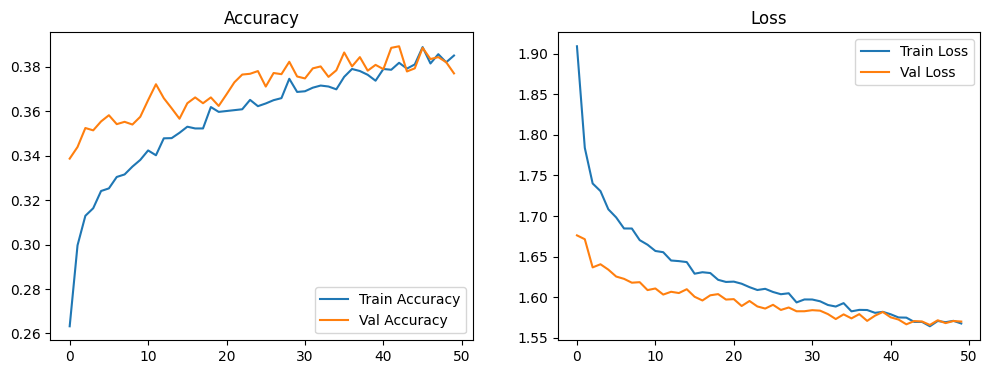

In [28]:
# Step 6: Visualize Results
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)

In [29]:
# Save the final model
model.save('fer_resnet50v2_final.h5')